# IDEAS
Perform umap on the proportions per domain and device instead of the graph embedding
Remove outlier domains
Remove domains that are irrelevant to the label -basically dont have correlation or mutual info to the label, and that dont modulate other important features

In [1]:
import os
import sqlite3
from multiprocessing import freeze_support
from modin.db_conn import ModinDatabaseConnection
import modin.pandas as mpd
%load_ext autoreload
%autoreload 2
os.environ["MODIN_ENGINE"] = "ray"  # Modin will use Ray
import ray
ray.init(ignore_reinit_error=True)
def load_data_from_db(con):
    try:
        df = mpd.read_sql("SELECT * FROM data", con)
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        raise


freeze_support()
dbfile = '/workspace/data/mini_training_set.db'

conn = ModinDatabaseConnection('sqlalchemy', f'sqlite:///{dbfile}')

# Can use get_connection to get underlying sqlalchemy engine
conn.get_connection()
db_df = load_data_from_db(conn)
print(db_df.head())

2025-03-12 18:32:12,394	INFO worker.py:1841 -- Started a local Ray instance.


   Device_ID                   Datetime      URL  Domain_Name  Domain_cls1  \
0        124  2023-04-23 03:04:30+03:00     6466      2368671          755   
1        124  2023-04-23 03:04:30+03:00  2245864      1792903            0   
2        124  2023-04-23 03:04:30+03:00  1839478       107342          332   
3        124  2023-04-23 03:14:50+03:00  1172090       107342          332   
4        124  2023-04-23 03:14:50+03:00  1839478       107342          332   

   Domain_cls2  Domain_cls3  Domain_cls4  Target  
0          799            0            0       0  
1            0            0            0       0  
2            0            0            0       0  
3            0            0            0       0  
4            0            0            0       0  


In [2]:
# "23-04 to 18-05"
db_df = db_df[db_df["Domain_Name"]!=1732927] # remove empty url
db_df["Datetime"] = mpd.to_datetime(db_df["Datetime"])
db_df["Datetime"]
# db_df.groupby("Device_ID").apply(lambda x: (x-x["Datetime"].min()).dt.days)

0          2023-04-23 03:04:30+03:00
1          2023-04-23 03:04:30+03:00
2          2023-04-23 03:04:30+03:00
3          2023-04-23 03:14:50+03:00
4          2023-04-23 03:14:50+03:00
                      ...           
32248978   2023-05-13 21:26:02+03:00
32248979   2023-05-13 21:26:03+03:00
32248980   2023-05-13 21:32:33+03:00
32248981   2023-05-13 21:32:38+03:00
32248982   2023-05-13 21:32:43+03:00
Name: Datetime, Length: 32237806, dtype: datetime64[ns, UTC+03:00]

In [3]:
# %%writefile preprocessing.py
from sklearn.model_selection import train_test_split
def get_train_test_masks(domain_counts, test_size=0.2, random_state=42):
    # Get unique device IDs and their corresponding targets
    device_target_df = domain_counts.groupby('Device_ID')['Target'].first().reset_index()
    
    # Perform stratified split on device IDs
    train_device_ids, test_device_ids = train_test_split(
        device_target_df['Device_ID'],
        test_size=test_size,
        random_state=random_state,
        stratify=device_target_df['Target']
    )
    
    # Create mask for train/test split in domain_counts
    train_mask = domain_counts['Device_ID'].isin(train_device_ids)
    test_mask = domain_counts['Device_ID'].isin(test_device_ids)
    
    # Print statistics
    print(f"Total devices: {len(device_target_df)}")
    print(f"Train devices: {len(train_device_ids)}")
    print(f"Test devices: {len(test_device_ids)}")
    print(f"\nTrain samples: {len(domain_counts[train_mask])}")
    print(f"Test samples: {len(domain_counts[test_mask])}")
    
    # Print class distribution
    print("\nTarget distribution in train set:")
    print(domain_counts[train_mask].groupby('Target').size() / len(domain_counts[train_mask]))
    print("\nTarget distribution in test set:")
    print(domain_counts[test_mask].groupby('Target').size() / len(domain_counts[test_mask]))
    
    return train_mask, test_mask

def get_domain_counts(db_df, pivot=False):
    domain_counts = db_df.groupby(["Device_ID","Domain_Name","Target"]).count()
    domain_counts = domain_counts.reset_index()
    domain_counts = domain_counts[["Device_ID","Domain_Name","Target","Datetime"]]
    domain_counts.rename(columns={"Datetime":"count"}, inplace=True)
    if pivot:
        pivot_matrix = domain_counts.pivot(index='source', columns='target', values='count').fillna(0)
        return pivot_matrix
    return domain_counts
def get_device_domain_fractions(domain_counts,inplace=True):
    # Calculate total counts per device
    device_totals = domain_counts.groupby('Device_ID')['count'].sum()
    
    # Calculate fractions by dividing each count by the device total
    domain_fractions = domain_counts if inplace else domain_counts.copy()
    domain_fractions['fraction'] = domain_fractions.apply(
        lambda row: row['count'] / device_totals[row['Device_ID']], 
        axis=1
    )
    
    return domain_fractions
def compute_domain_target_correlation(domain_counts):
    # Group by Domain_Name and calculate mean Target and count
    get_corr = lambda x : x.target*2-1 if x.target.std()==0 else x['min_max_fraction'].corr(x['Target'])
    n_devices = domain_counts.groupby('Domain_Name')["Device_ID"].nunique()
    n_devices = n_devices[n_devices>3]
    domain_counts = domain_counts[domain_counts["Domain_Name"].isin(n_devices.index)]
    domain_targets = domain_counts.groupby('Domain_Name').apply(lambda x: mpd.DataFrame({
        'target_correlation': [ x['min_max_fraction'].corr(x['Target'])],
        'avg_count': [x['count'].mean()],
        'count_std': [x['count'].std()],
        'n_devices': [len(x['Device_ID'].unique())]
    }))
    return domain_targets

In [4]:
print("keep in mind that the best resolution will be achieved with a resolution of urls/chain of urls, not domains")
print("Cluster url walks")
print("I want to cluster urls/url walks from a given domain, to 3 categories")
print("positive correlation, zero correlation, negative correlation, to_label")

keep in mind that the best resolution will be achieved with a resolution of urls/chain of urls, not domains
Cluster url walks
I want to cluster urls/url walks from a given domain, to 3 categories
positive correlation, zero correlation, negative correlation, to_label


### Getting Basic features ( Domain Counts )

In [5]:

domain_counts = get_domain_counts(db_df)
del db_df
device_domain_fractions = get_device_domain_fractions(domain_counts)
device_domain_fractions["min_max_fraction"] = (device_domain_fractions["fraction"]-device_domain_fractions["fraction"].min())/(device_domain_fractions["fraction"].max()-device_domain_fractions["fraction"].min())
domain_target_correlation = compute_domain_target_correlation(domain_counts)

train_mask, test_mask = get_train_test_masks(domain_counts)
train_devices = domain_counts.loc[train_mask,"Device_ID"]
test_devices = domain_counts.loc[test_mask,"Device_ID"]




(_remote_exec_single_chain pid=222135) FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
(_deploy_ray_func pid=222121) FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
(_deploy_ray_func pid=222128) RuntimeWarning: invalid value encountered in divide
(_deploy_ray_func pid=222128) RuntimeWarning: invalid value encountered in divide
(_remote_exec_multi_chain pid=222126) FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version. [repeated 79x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(remote_exec_func pid=222121) FutureWarning: The 'downcast' keyword i

Total devices: 615
Train devices: 492
Test devices: 123

Train samples: 229983
Test samples: 57590

Target distribution in train set:
Target
0    0.466521
1    0.533479
dtype: float64

Target distribution in test set:
Target
0    0.437003
1    0.562997
dtype: float64


In [6]:
train_fraction_pivot_matrix = device_domain_fractions.pivot(index='Domain_Name', columns='Device_ID', values='fraction').fillna(0)

In [7]:
# %%writefile correlation.py
import numpy as np
import ray

@ray.remote
def calculate_chunk_correlation(matrix_centered, std_values, start_idx, end_idx, columns):
    # Calculate correlation for this chunk
    chunk = matrix_centered[:, start_idx:end_idx]
    # Avoid division by zero by handling zero standard deviations
    valid_std = (std_values > 0)
    chunk_corr = np.zeros((end_idx - start_idx, len(columns)))
    
    # Calculate correlation only for columns with non-zero standard deviation
    if valid_std.any():
        chunk_corr = np.dot(chunk.T, matrix_centered[:, valid_std])
        chunk_corr /= ((matrix_centered.shape[0] - 1) * 
                      np.outer(std_values[start_idx:end_idx], 
                             std_values[valid_std]))
    
    return start_idx, end_idx, chunk_corr
@ray.remote
def calculate_chunk_covariance(matrix_centered, start_idx, end_idx, columns):
    # Calculate covariance for this chunk
    chunk = matrix_centered[:, start_idx:end_idx]
    chunk_cov = np.dot(chunk.T, matrix_centered) / (matrix_centered.shape[0] - 1)
    
    return start_idx, end_idx, chunk_cov

def compute_chunked_metric(pivot_matrix, batch_size=2000,metric="covariance"):
    # Convert to numpy array for faster computation
    matrix_dense = pivot_matrix.to_numpy()
    matrix_centered = matrix_dense - np.mean(matrix_dense, axis=0)

    # Initialize parameters
    n_cols = pivot_matrix.shape[1]
    futures = []
    metric_func = calculate_chunk_covariance if metric=="covariance" else calculate_chunk_correlation if metric=="correlation" else None
    # Submit tasks to Ray
    for i in range(0, n_cols, batch_size):
        batch_end = min(i + batch_size, n_cols)
        futures.append(metric_func.remote(matrix_centered, i, batch_end, pivot_matrix.columns))

    # Collect results and combine
    cov_chunks = []
    for future in ray.get(futures):
        start_idx, end_idx, chunk_cov = future
        chunk_df = mpd.DataFrame(
            chunk_cov,
            index=pivot_matrix.columns[start_idx:end_idx],
            columns=pivot_matrix.columns
        )
        cov_chunks.append(chunk_df)

    # Combine all chunks
    return mpd.concat(cov_chunks)
def melt_covariance_matrix(covariance_matrix):
    # Reset index to make it a column
    melted = covariance_matrix.reset_index()
    
    # Melt the dataframe
    melted = melted.melt(
        id_vars=['Device_ID'],
        var_name='target',
        value_name='covariance'
    )
    
    # Rename the 'index' column to 'source'
    melted = melted.rename(columns={'Device_ID': 'source'})
    
    # Remove duplicate pairs (e.g., if A->B exists, remove B->A)
    melted = melted[melted['source'] < melted['target']]
    
    # Remove rows where source equals target
    melted = melted[melted['source'] != melted['target']]
    
    return melted.reset_index(drop=True)
def filter_and_transform_covariance(melted_covariance, abs_threshold=0.03, log_threshold=10):
    # Create a copy to avoid modifying the original dataframe
    result = melted_covariance
    # Create corrected_cov column
    result['corrected_cov'] = result['covariance'].copy()
    
    # Apply absolute threshold filter
    result.loc[abs(result['corrected_cov']) < abs_threshold, 'corrected_cov'] = 0
    
    # Apply log transformation for values above log_threshold
    high_vals_mask = abs(result['corrected_cov']) > log_threshold
    result.loc[high_vals_mask, 'corrected_cov'] = result.loc[high_vals_mask, 'corrected_cov'].apply(
        lambda x: np.log(abs(x)) * np.sign(x)
    )
    print(high_vals_mask.mean())
    
    return result

### Calculating Covariance/Correlation between domains


In [8]:
# Get domain counts and create pivot matrix

# Compute covariance matrix and melt it
covariance_matrix = compute_chunked_metric(train_fraction_pivot_matrix) * 10000
melted_cov = melt_covariance_matrix(covariance_matrix)
melted_cov["min_max_cov"] = (melted_cov["covariance"]-melted_cov["covariance"].min())/(melted_cov["covariance"].max()-melted_cov["covariance"].min())

# corrected_cov = filter_and_transform_covariance(melted_cov)



Order of rows could be different from pandas.


In [9]:
# %%writefile graph_model_funcs.py
from sklearn.model_selection import train_test_split
import torch
from torch_geometric.nn import Node2Vec
from torch_geometric.data import Data
import networkx as nx
import pandas as pd
import numpy as np

DEFAULT_NODE2_VEC_PARAMS = dict(embedding_dim=128,
walk_length=80,
context_size=10,
walks_per_node=10,
p=1,
q=1.5,
sparse=True)
def create_graph_data(corrected_cov,weight_col):
    # Convert domain names to numerical indices
    unique_domains = list(set(corrected_cov['source']).union(corrected_cov['target']))
    domain_to_idx = {domain: idx for idx, domain in enumerate(unique_domains)}
    
    # Create edge index and edge weights
    edge_index = torch.tensor([
        [domain_to_idx[s] for s in corrected_cov['source']],
        [domain_to_idx[t] for t in corrected_cov['target']]
    ], dtype=torch.long)
    
    edge_weight = torch.tensor(corrected_cov[weight_col].values, dtype=torch.float)
    
    # Create PyTorch Geometric Data object
    data = Data(
        edge_index=edge_index,
        edge_attr=edge_weight,
        num_nodes=len(unique_domains)
    )
    return data, domain_to_idx

def train_node2vec(data, node2vec_params=DEFAULT_NODE2_VEC_PARAMS,device='cuda'):
    device = torch.device("cpu")#device if torch.cuda.is_available() else 'cpu')
    model = Node2Vec(
        data.edge_index,
        **node2vec_params
    ).to(device)

    
    model.train()
            
    return model
@ray.remote
def _compute_device_embedding(device_id, group, embeddings, domain_mapping):
    valid_embeddings = []
    valid_weights = []
    
    for _, row in group.iterrows():
        domain = row['Domain_Name']
        if domain in domain_mapping:
            idx = domain_mapping[domain]
            valid_embeddings.append(embeddings[idx])
            valid_weights.append(row['fraction'])
    
    if valid_embeddings:
        valid_weights = np.array(valid_weights)
        valid_weights = valid_weights / valid_weights.sum()
        device_embedding = np.average(valid_embeddings, weights=valid_weights, axis=0)
        return device_id, device_embedding
    return device_id, None

def compute_device_embeddings(device_fractions, embeddings, domain_mapping):
    # Group device fractions by Device_ID
    grouped_fractions = device_fractions.groupby('Device_ID')
    
    # Create remote tasks
    futures = [
        _compute_device_embedding.remote(device_id, group, embeddings, domain_mapping)
        for device_id, group in grouped_fractions
    ]
    
    # Collect results
    results = ray.get(futures)
    
    # Convert results to dictionary
    device_embeddings = {
        device_id: embedding 
        for device_id, embedding in results 
        if embedding is not None
    }
    
    return device_embeddings
# def create_graph_and_get_embedding(corrected_cov,weight_col,device='cuda'node2vec_params):
#     data, domain_mapping = create_graph_data(corrected_cov,weight_col)
#     model = train_node2vec(data,device=device,**node2vec_params)
#     embeddings = model.embedding.weight.cpu().detach().numpy()
#     # device_embeddings = compute_device_embeddings(device_domain_fractions, embeddings, domain_mapping)
#     return embeddings,domain_mapping



### Train Node2Vec

In [10]:
# train_mask, test_mask = get_train_test_masks(domain_counts)
final_device_domain_fractions = device_domain_fractions[["Device_ID","Domain_Name","min_max_fraction"]].rename(columns={"Domain_Name":"target","Device_ID":"source","min_max_fraction":"weight"})
final_cov = melted_cov[["source","target","min_max_cov"]].rename(columns={"min_max_cov":"weight"})
final_df = mpd.concat([final_device_domain_fractions,final_cov],ignore_index=True)
data, domain_mapping = create_graph_data(final_df,weight_col="weight")
node_to_vec_params = {'embedding_dim': 32, 'walk_length': 40, 'context_size': 10, 'walks_per_node': 5, 'p': 0.5, 'q': 1, 'sparse': False}
model = train_node2vec(data,node2vec_params=node_to_vec_params)
embeddings = model().detach().cpu().numpy()

In [11]:
node_df = mpd.Series(domain_mapping)

In [13]:
node_map_df = mpd.Series(domain_mapping,name="idx").to_frame()
train_emb_indices = node_map_df.loc[train_devices,"idx"].to_list()
print(train_devices)
test_emb_indices = node_map_df.loc[test_devices,"idx"].to_list()
labels = domain_counts[["Device_ID","Target"]].drop_duplicates(subset="Device_ID").set_index("Device_ID")

labeled_node_df = node_df.to_frame().merge(labels,left_index=True,right_index=True,how="right")

Please refer to https://modin.readthedocs.io/en/stable/supported_apis/defaulting_to_pandas.html for explanation.


0           124
1           124
2           124
3           124
4           124
          ...  
287568    69967
287569    69967
287570    69967
287571    69967
287572    69967
Name: Device_ID, Length: 229983, dtype: int64


In [14]:
labeled_node_df.rename(columns={0:"idx"},inplace=True)
node_df.name = "idx"

In [15]:
domain_target_correlation.index = domain_target_correlation.index.get_level_values(0)

In [16]:
devices_embedding_idx = labeled_node_df["idx"].tolist()

domain_target_corr_w_emb_idx = domain_target_correlation[["target_correlation"]].merge(node_df,left_index=True,right_index=True,how="inner")
domain_target_corr_w_emb_idx.index.name="Domain_Name"
domain_embedding_idx = domain_target_corr_w_emb_idx["idx"].tolist()

In [33]:
import umap
reducer = umap.UMAP(n_jobs=-1,n_neighbors=3)
embeddings_2d = reducer.fit_transform(embeddings)

In [34]:
device_embeddings = embeddings_2d[devices_embedding_idx]

domain_embeddings = embeddings_2d[domain_embedding_idx]
device_labels = labeled_node_df["Target"].tolist()


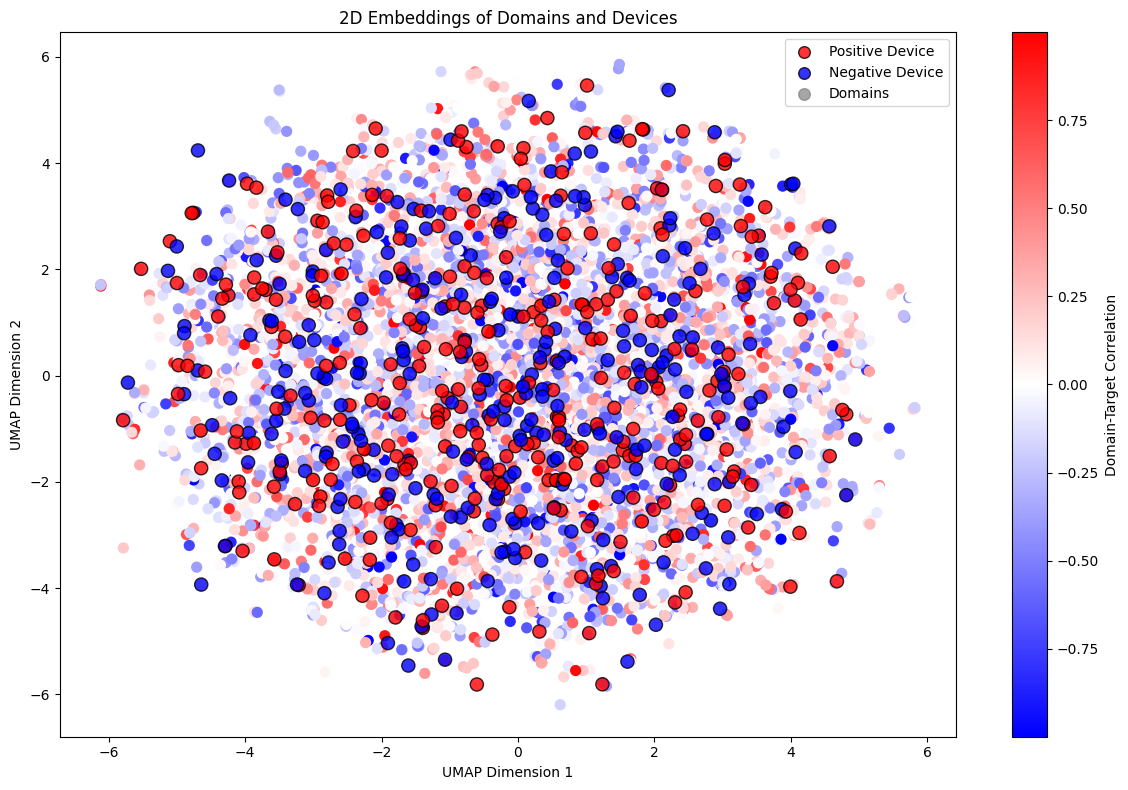

In [41]:
import matplotlib.pyplot as plt

# Create the figure
plt.figure(figsize=(12, 8))

# Plot domains - colored by correlation with target
domain_scatter = plt.scatter(
    domain_embeddings[:, 0], 
    domain_embeddings[:, 1],
    c=domain_target_corr_w_emb_idx['target_correlation'],
    cmap='bwr',
    alpha=1.0,
    marker='o',
    s=50,
        # edgecolors='black'

)

# Plot devices - colored by target label
device_scatter = plt.scatter(
    device_embeddings[:, 0], 
    device_embeddings[:, 1],
    c=device_labels,
    cmap='bwr',
    alpha=0.8,
    s=90,
    marker='o',
    edgecolors='black'
)

# Add colorbars
plt.colorbar(domain_scatter, label='Domain-Target Correlation')

# Add legend
legend_elements = [
    plt.scatter([], [], c='red', s=70, label='Positive Device', alpha=0.8, edgecolors='black'),
    plt.scatter([], [], c='blue', s=70, label='Negative Device', alpha=0.8, edgecolors='black'),
    plt.scatter([], [], c='gray', s=70, label='Domains', alpha=0.7)
]
plt.legend(handles=legend_elements)

plt.title('2D Embeddings of Domains and Devices')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.tight_layout()
plt.show()

In [20]:
devices = train_devices.tolist()+test_devices.tolist()

In [21]:

dict(embedding_dim=128,
walk_length=80,
context_size=10,
walks_per_node=10,
p=1,
q=1.5,
sparse=True)

{'embedding_dim': 128,
 'walk_length': 80,
 'context_size': 10,
 'walks_per_node': 10,
 'p': 1,
 'q': 1.5,
 'sparse': True}

### Infer Test Embeddings

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import numpy as np
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier

def train_xgboost(embeddings, node_map_df, domain_counts, train_devices, test_devices):
    # Get device embeddings for training and testing

    train_emb_indices = node_map_df.loc[train_devices]
    test_emb_indices = node_map_df.loc[test_devices]
    train_device_embeddings = mpd.DataFrame(embeddings[train_emb_indices],index=train_devices)
    test_device_embeddings = mpd.DataFrame(embeddings[test_emb_indices],index=test_devices)
    domain_counts_w_index = domain_counts.drop_duplicates(subset="Device_ID").set_index("Device_ID")

    # Prepare training data
    X_train = train_device_embeddings
    y_train = domain_counts_w_index.loc[train_devices, 'Target'].values

    # Prepare test data
    X_test = test_device_embeddings
    y_test = domain_counts_w_index.loc[test_devices, 'Target'].values

    # Initialize and train Logistic Regression
    # Initialize and train XGBoost classifier
    xgb_model = xgb.XGBRegressor(objective='binary:logistic', random_state=42)
    xgb_model.fit(X_train, y_train)

    # Get predictions and calculate ROC AUC score
    y_pred_proba = xgb_model.predict(X_test)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print(f"ROC AUC Score: {roc_auc:.4f}")
    return roc_auc
def train_knn(embeddings, train_emb_indices,test_emb_indices, labels, train_devices, test_devices, n_neighbors):
    # Get device embeddings for training and testing

    train_device_embeddings = pd.DataFrame(embeddings[train_emb_indices], index=train_devices)
    test_device_embeddings = pd.DataFrame(embeddings[test_emb_indices], index=test_devices)

    
    # Prepare training data
    X_train = train_device_embeddings
    y_train = labels.loc[train_devices, 'Target'].values
    
    # Prepare test data
    X_test = test_device_embeddings
    y_test = labels.loc[test_devices, 'Target'].values
    
    # Initialize and train KNN classifier
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    
    # Get predictions and calculate ROC AUC score
    y_pred_proba = knn.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f"ROC AUC Score: {roc_auc:.4f}")
    return roc_auc


Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.


In [23]:
import itertools


grid_dict = {"embedding_dim":[32,64,128,256],"walk_length":[20,40,80,160],"context_size":[5,10,20],"walks_per_node":[5,10,20],"p":[0.5,1,1.5],"q":[0.5,1,1.5],"sparse":[True,False]}
# Get all combinations of parameters
param_keys = list(grid_dict.keys())
param_values = list(grid_dict.values())
param_combinations = list(itertools.product(*param_values))
param_combinations = [param_combinations[i] for i in np.random.choice(range(len(param_combinations)), 500)]



In [24]:
node_map_df = mpd.Series(domain_mapping,name="idx").to_frame()
train_emb_indices = node_map_df.loc[train_devices,"idx"].to_list()
print(train_devices)
test_emb_indices = node_map_df.loc[test_devices,"idx"].to_list()
labels = domain_counts[["Device_ID","Target"]].drop_duplicates(subset="Device_ID").set_index("Device_ID")


0           124
1           124
2           124
3           124
4           124
          ...  
287568    69967
287569    69967
287570    69967
287571    69967
287572    69967
Name: Device_ID, Length: 229983, dtype: int64


In [25]:
# Clean up unused variables to free memory
del param_combinations
del param_values
del param_keys
del grid_dict
del melted_cov
del covariance_matrix
del final_cov
del final_device_domain_fractions

In [26]:
auc = train_knn(
            embeddings=embeddings,
            labels=labels,
            train_emb_indices=train_emb_indices,
            test_emb_indices=test_emb_indices,
            train_devices=train_devices,
            test_devices=test_devices,
            n_neighbors=4
        )
print(auc)

ROC AUC Score: 0.5520
0.5519891403866486


In [27]:
from ray import tune
from ray.tune.search.optuna import OptunaSearch
from functools import partial
from ipython.display import display


def optimize_knn(data, train_emb_indices,test_emb_indices, labels,train_devices, test_devices):
    def objective(config, data, train_emb_indices,test_emb_indices, labels,train_devices, test_devices):
        # Create and train model with the suggested parameters
        model = train_node2vec(data, config)
        
        embeddings = model().detach().cpu().numpy()
        
        # Evaluate using KNN
        auc = train_knn(
            embeddings=embeddings,
            labels=labels,
            train_emb_indices=train_emb_indices,
            test_emb_indices=test_emb_indices,
            train_devices=train_devices,
            test_devices=test_devices,
            n_neighbors=4
        )
        
        # Report the score to Tune
        tune.report({"auc":auc})

    # Define the search space
    search_space = {
        "embedding_dim": tune.choice([32, 64, 128, 256]),
        "walk_length": tune.choice([20, 40, 80, 160]),
        "context_size": tune.choice([5, 10, 20]),
        "walks_per_node": tune.choice([5, 10, 20]),
        "p": tune.choice([0.5,1,1.5]),
        "q": tune.choice([0.5,1,1.5]),
        "sparse": tune.choice([True, False])
    }

    # Create the Optuna search algorithm
    optuna_search = OptunaSearch(
        metric="auc",
        mode="max"
    )

    experiment_fn = partial(
            objective,
            data=data,
            train_devices=train_devices.values,
            test_devices=test_devices.values,
            train_emb_indices=train_emb_indices,
            test_emb_indices=test_emb_indices,
            labels=labels
        )

        # Run the optimization with tune.run
    analysis = tune.run(
            experiment_fn,
            config=search_space,
            search_alg=optuna_search,
            num_samples=200,
            reuse_actors=True,
            # max_concurrent_trials=20,# Number of trials to run
            # resources_per_trial={"cpu": 1},  # Main process + 1 worker process
        # Adjust based on your resources
            metric="auc",
            mode="max",
        )
    display(analysis.dataframe().sort_values("auc",ascending=False).head())
    return analysis
# Get best config and score
# best_config = analysis.get_best_config(metric="auc", mode="max")
# best_trial = analysis.get_best_trial(metric="auc", mode="max")
# print("Best config:", best_config)
# print("Best AUC:", best_trial.last_result["auc"])

ModuleNotFoundError: No module named 'ipython'

In [ ]:

# train_xgboost(embeddings, node_map_df, domain_counts, train_devices, test_devices)
